In [2]:
import sys

try:
    __file__
except:
    sys.argv = [sys.argv[0],'--dynet-gpu', '--dynet-mem', '4000']
import matplotlib.pyplot as plt
import dynet as dy


In [3]:

ha_air_control = [['ground_mult','ground_gravity','ground_reset'],
                   ['0','up-control_gravity','up-control_reset'],
                   ['up-fixed_mult','up-fixed_gravity','up-fixed_reset'],
                   ['down_mult','down_gravity','down_reset']]
ha_fixed = [['ground_mult','ground_gravity','ground_reset'],
               ['up-fixed_mult','up-fixed_gravity','up-fixed_reset'],
               ['down_mult','down_gravity','down_reset']]

data = []
with open('HAs.csv') as infile:
    categories = infile.readline().rstrip().split('\t')
    cat2int = {c:i for i,c in enumerate(categories)}
    for line in infile:
        ha = line.rstrip().split('\t')
        ha = {c:ha[cat2int[c]] for c in cat2int}
        ha_flat = [['start','start','start']]
        structure = None
        transitions = None
        
        if ha['up-control_reset'] == 'None':
            for mode in ha_fixed:
                mode_flat = [] 
                for cat in mode:
                    mode_flat.append(float(int(float(ha[cat])*32)/32.0))
                ha_flat.append(mode_flat)
                
            structure = [0,1,1,2,2,0,3]
            transitions = [['start', 'Button','Press', '>=', 1.0, 'end'],
                           ['start', 'dy','<=',0.0, 'end'],
                           ['start', 'Collision','Bottom', 'end']]
        else:
            for mode in ha_air_control:
                mode_flat = []
                for cat in mode:
                    if cat == '0':
                        mode_flat.append(0)
                    else:
                        mode_flat.append(float(int(float(ha[cat])*32)/32.0))
                ha_flat.append(mode_flat)
                structure = [0,1,1,2,2,3,3,0,4]
                transitions = [['start', 'Button','Press', '>=', float(ha['minHoldDuration']), 'end'],
                               ['start', 'Button','Release',':','Button','Press', '>=', float(ha['maxHoldDuration']), 'end'],
                               ['start', 'dy','<=',0.0, 'end'],
                               ['start', 'Collision','Bottom', 'end']]
        ha_flat.append(['end','end','end'])
                
        data.append((ha_flat,structure,transitions))
#print data

In [16]:
node_vocab = set()

for d in data:
    for n in d[0]:
        node_vocab |= set(n)
             
node_v2i = {e:i for i,e in enumerate(sorted(node_vocab))}
    
node_size = len(data[0][0][0])


node_generation_dropout = 0.25
node_generation_state_size = 512
node_generation_embeddings_size = int(len(node_v2i)/8)

node_generation_layers = 1

####
edge_detection_dropout = 0.25
edge_detection_state_size = 512
edge_detection_layers = 1

######
edge_vocab = set()
for d in data:
    for e in d[2]:
        edge_vocab |= set(e)
        
edge_v2i = {e:i for i,e in enumerate(sorted(edge_vocab))}
edge_i2v = {i:e for i,e in enumerate(sorted(edge_vocab)) }
edge_vocab_size = len(edge_v2i)


edge_embeddings_size = int(len(edge_i2v)/8)
edge_dropout = 0.25
edge_state_size = 512
edge_layers = 1
#########

node_size = 3

model = dy.Model()

node_generation_embedding = model.add_lookup_parameters((len(node_v2i), node_generation_embeddings_size))
node_generator_rnn = dy.LSTMBuilder(node_generation_layers, node_generation_embeddings_size*node_size, node_generation_state_size, model)
node_generator_rnn.set_dropout(node_generation_dropout)
node_generator_ws = [model.add_parameters((len(node_v2i), node_generation_state_size)) for ii in range(node_size)]
node_generator_bs = [model.add_parameters((len(node_v2i))) for ii in range(node_size)]

edge_detection_rnn = dy.LSTMBuilder(edge_detection_layers, node_generation_state_size, edge_detection_state_size, model)
edge_detection_rnn.set_dropout(edge_detection_dropout)
edge_attention_w1 = model.add_parameters((node_generation_state_size, node_generation_state_size))
edge_attention_w2 = model.add_parameters((node_generation_state_size, edge_detection_state_size))
edge_attention_v = model.add_parameters((1, node_generation_state_size))

edge_embedding = model.add_lookup_parameters((len(edge_v2i), edge_embeddings_size))
edge_rnn = dy.LSTMBuilder(edge_layers, edge_embeddings_size+node_generation_state_size*3, edge_state_size, model)
edge_rnn.set_dropout(edge_dropout)
edge_w = model.add_parameters((edge_vocab_size, edge_state_size))
edge_b = model.add_parameters((edge_vocab_size))
edge_generation_attention_w1 = model.add_parameters((node_generation_state_size, node_generation_state_size))
edge_generation_attention_w2 = model.add_parameters((node_generation_state_size, edge_state_size))
edge_generation_attention_v = model.add_parameters((1, node_generation_state_size))


In [18]:
import numpy as np
node_i2v = {i:e for i,e in enumerate(sorted(node_vocab))}
    
trainer = dy.RMSPropTrainer(model)

def attend(input_vectors,state,w1,w2,v):
    w1 = dy.parameter(edge_attention_w1)
    w2 = dy.parameter(edge_attention_w2)
    v = dy.parameter(edge_attention_v)
    attention_weights = []

    w2dt = w2 * state.h()[-1]
    for input_vector in input_vectors:
        attention_weight = v * dy.tanh(w1 * input_vector + w2dt)
        attention_weights.append(attention_weight)
    attention_weights = dy.softmax(dy.concatenate(attention_weights))
    output_vectors = dy.esum(
            [vector * attention_weight for vector, attention_weight in zip(input_vectors, attention_weights)])
    return output_vectors,attention_weights

def train(automata,show_loss,mode_gen_weight=1.0,edge_detection_weight=1.0,edge_translation_weight=10.0):  
    dy.renew_cg()      
    states = []
    node_generator_state = node_generator_rnn.initial_state()
    #Node Generation Portion
    input_mode = dy.concatenate([node_generation_embedding[node_v2i[pt]] for pt in automata[0][0]])
    loss = []
    for mode in automata[0][1:]:
        node_generator_state = node_generator_state.add_input(input_mode)
        #We savpt[0]e these for use with the Edge detector/Edge Generator
        states.append(node_generator_state.output())                    
        node_output = states[-1]
        predictions = [dy.softmax(dy.parameter(w)*node_output+dy.parameter(b)) for w,b in zip(node_generator_ws,node_generator_bs)]
                        
        input_mode = dy.concatenate([node_generation_embedding[node_v2i[pt]] for pt in mode])
        
        
        for prediction,actual in zip(predictions,mode):
            loss.append(mode_gen_weight*-dy.log(dy.pick(prediction,node_v2i[actual])))
    #Pointer Network using the aforementioned states
    pointer_state = edge_detection_rnn.initial_state()
    pointer_state = pointer_state.add_input(dy.vecInput(node_generation_state_size))
    probs = []
    for pt in automata[1]:
        attended_encoding, attention_probabilities = attend(states, pointer_state,
                                                            edge_attention_w1,
                                                            edge_attention_w2,
                                                            edge_attention_v)
        pointer_state = pointer_state.add_input(attended_encoding)        
        probs.append(attention_probabilities.value())
        loss.append(edge_detection_weight*-dy.log(dy.pick(attention_probabilities, pt)))
                
    #Edge Generator        
    for pt_id, pt in enumerate(automata[2][:]):
        mode1 = states[automata[1][pt_id*2]]
        mode2 = states[automata[1][pt_id*2+1]]
        
        edge_state = edge_rnn.initial_state()
        edge_state = edge_state.add_input(dy.concatenate([edge_embedding[edge_v2i[pt[0]]],
                                                          mode1,
                                                          mode2,
                                                          dy.vecInput(node_generation_state_size)]))
        
        for cond in pt[0:]:
            attended_encoding, attention_probabilities = attend(states, edge_state,
                                                            edge_generation_attention_w1,
                                                            edge_generation_attention_w2,
                                                            edge_generation_attention_v)
            edge_state = edge_state.add_input(dy.concatenate([edge_embedding[edge_v2i[cond]],mode1,mode2,attended_encoding]))
            
            probs = dy.softmax(dy.parameter(edge_w)*edge_state.output()+dy.parameter(edge_b))
            loss.append(edge_translation_weight*-dy.log(dy.pick(probs,edge_v2i[cond])))
            
        
    loss = dy.esum(loss)
    if show_loss:
        print loss.value()
    
    loss.backward()
    trainer.update()
def predict(probabilities,temperature=0.10):
    output = []
    for prob in probabilities:
        prob = np.array(prob.value())
        prob = np.log(prob)/temperature
        prob = np.exp(prob)
        prob /= np.sum(prob)
        output.append(np.argmax(np.random.multinomial(1, prob, 1)))
    return output
        
def generate():
    dy.renew_cg()   
    node_generator_state = node_generator_rnn.initial_state()
    mode = ['start','start','start']
    
    input_mode = dy.concatenate([node_generation_embedding[node_v2i[pt]] for pt in mode])
    node_generator_state = node_generator_state.add_input(input_mode)
    node_output = node_generator_state.output()
    predictions = [dy.softmax(dy.parameter(w)*node_output+dy.parameter(b)) for w,b in zip(node_generator_ws,node_generator_bs)]
    all_output = []
    states = [node_generator_state.output()]
    for ii in range(10):
        output = predict(predictions)
        
        output = [node_i2v[o]  for o in output]
        if output[0] == 'end':
            all_output.append(output)
            break
        all_output.append(output)
        input_mode = dy.concatenate([node_generation_embedding[node_v2i[pt]] for pt in output])
        node_generator_state = node_generator_state.add_input(input_mode)
        states.append(node_generator_state.output())
        node_output = node_generator_state.output()
        predictions = [dy.softmax(dy.parameter(w)*node_output+dy.parameter(b)) for w,b in zip(node_generator_ws,node_generator_bs)]
    
    #Pointer Network using the aforementioned states
    pointer_state = edge_detection_rnn.initial_state()
    pointer_state = pointer_state.add_input(dy.vecInput(node_generation_state_size))
    probs = []
    prediction = 0
    predictions = []
    for ii in range(10):
        attended_encoding, attention_probabilities = attend(states, 
                                                            pointer_state,
                                                            edge_attention_w1,
                                                            edge_attention_w2,
                                                            edge_attention_v)
        pointer_state = pointer_state.add_input(attended_encoding) 
        prediction = predict([attention_probabilities])
        if prediction[0] == len(states)-1:
            break
        predictions.append(prediction[0])
    links = [(predictions[i],predictions[i+1]) for i in range(0,len(predictions)-1,2)]
    
          
    #Edge Generator 
    all_edges = []
    for link in links:
        mode1 = states[link[0]]
        mode2 = states[link[1]]
                
        edge_state = edge_rnn.initial_state()
        edge_state = edge_state.add_input(dy.concatenate([edge_embedding[edge_v2i['start']],
                                                          mode1,
                                                          mode2,
                                                          dy.vecInput(node_generation_state_size)]))
        edge_predictions = []
        
        probs = dy.softmax(dy.parameter(edge_w)*edge_state.output()+dy.parameter(edge_b))
        output = predict([probs])
        
        
        for ii in range(20):
            
            attended_encoding, attention_probabilities = attend(states, 
                                                                edge_state,
                                                                edge_generation_attention_w1,
                                                                edge_generation_attention_w2,
                                                                edge_generation_attention_v)
            
            edge_state = edge_state.add_input(dy.concatenate([edge_embedding[output[0]],
                                                              mode1,
                                                              mode2,
                                                              attended_encoding]))
            
            probs = dy.softmax(dy.parameter(edge_w)*edge_state.output()+dy.parameter(edge_b))
            
            output = predict([probs])
            if edge_i2v[output[0]] == 'end':
                break
            edge_predictions.append(edge_i2v[output[0]])
        edge_predictions = edge_predictions[1:]
            #edge_state = edge_state.add_input(dy.concatenate([edge_embedding[output[0]],mode1,mode2]))
        print link[0],'->',link[1],edge_predictions
        all_edges.append(edge_predictions)
    return all_output,links,all_edges
        
    
for ii in range(50000):
    for pt_id,pt in enumerate(data[:]):
        train(pt,pt_id%35 == 0 and ii % 50 == 0)
    if ii % 50 == 0:        
        print ii
        print generate() 

12.409029007
8.46154499054
0
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.25], [0.0, 0.375, -0.6875], ['end', 'end', 'end']], [(0, 1), (1, 2)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0]])
6.86452817917
7.61500501633
50
0 -> 1 ['Button', 'Press', '>=', 4.0]
1 -> 2 ['Button', 'Release', ':', 'Button', 'Press', '>=', 8.0]
2 -> 3 ['dy', '<=', 0.0]
3 -> 0 ['Collision', 'Bottom']
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.5], [0.1875, 0.375, -3.875], [0.375, 0.375, 0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 4.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 8.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
6.0667142868
7.57244586945
100
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['Button', 'Release', ':', 'Button', 'Press', '>=', 12.0]
2 -> 3 ['dy', '<=', 0.0]
3 -> 0 ['Collision', 'Bottom']
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.5], [-0.25, 0.1875, -3.875], [0.0, 0.21875, -0.09375], [

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:85: RuntimeWarning: divide by zero encountered in log


6.07986545563
9.17510604858
850
0 -> 1 ['Button', 'Press', '>=', 2.0]
1 -> 2 ['Button', 'Release', ':', 'Button', 'Press', '>=', 24.0]
2 -> 3 ['dy', '<=', 0.0]
3 -> 0 ['Collision', 'Bottom']
([[0.0, 0.0, 0.0], [0.0, 0.03125, -4.09375], [0.84375, 0.375, 0.28125], [0.15625, 0.15625, 1.0625], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 2.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 24.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
6.39710140228
9.19197463989
900
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.25], [0.0, 0.1875, -0.6875], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
5.92316913605
9.10826301575
950
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.09375], [0.0, 0.1875, -0.125], ['end'

RuntimeError: Magnitude of gradient is bad: nan

In [19]:
has = [generate() for ii in range(2000)]
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:85: RuntimeWarning: divide by zero encountered in log


0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
0 -> 1 ['Button', 'Press', '>=', 1.0]
1 -> 2 ['dy', '<=', 0.0]
2 -> 0 ['Collision', 'Bottom']
0 -> 1 ['Button', 'Press', '>=', 1.0, 1.0]
1 -> 2 ['Button', 'Release', ':', 'Button', 'Press', '>=', 12.0]
2 -> 3 ['dy', '<=', 0.0]
3 -> 0 ['Collision', 'Bottom']
0 -> 1 ['Button', 'Pr

0
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.0, 0.28125, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


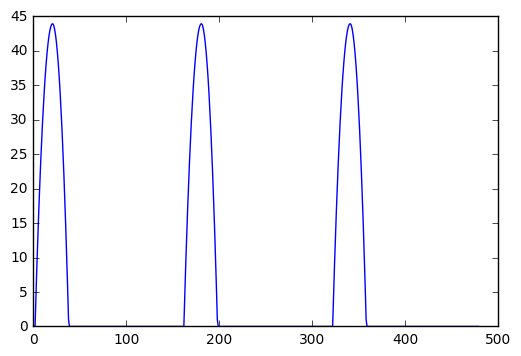

1
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.28125, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


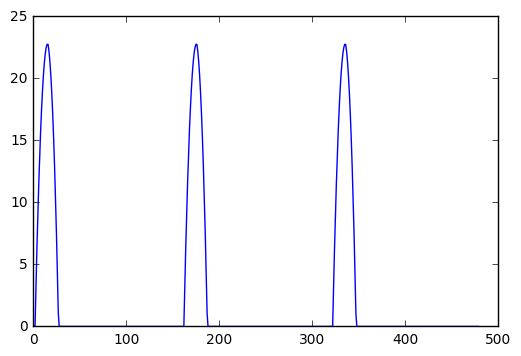

2
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.25], [0.0, 0.1875, -0.6875], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


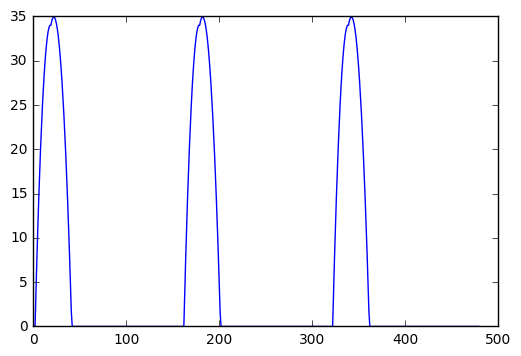

3
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.125, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


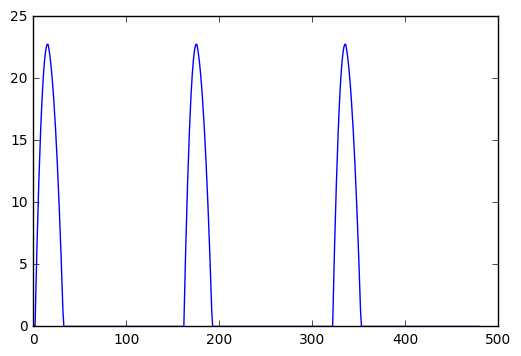

4
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.25], [0.0, 0.1875, -0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


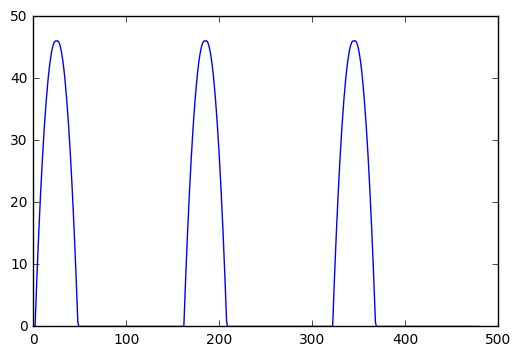

5
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.0, 0.25, 0.28125], ['end', 0.375, 'end']], [(0, 1), (1, 2)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0]])


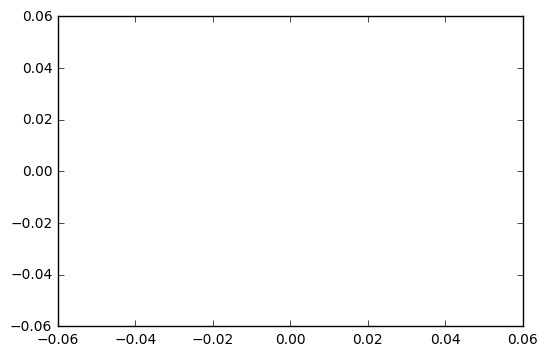

6
([[0.0, 0.0, 0.0], [0.0, 0.1875, -3.5], [0.0, 0.09375, -2.5625], ['end', 0.25, 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


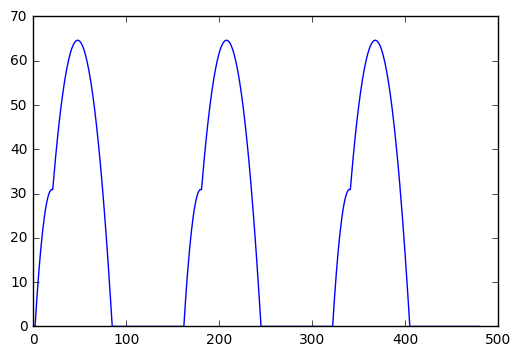

7
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.0, 0.25, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


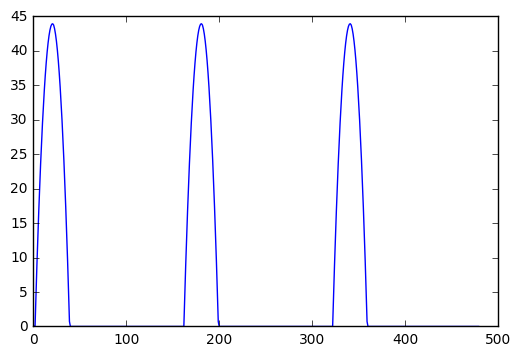

8
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.125, 0.0], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


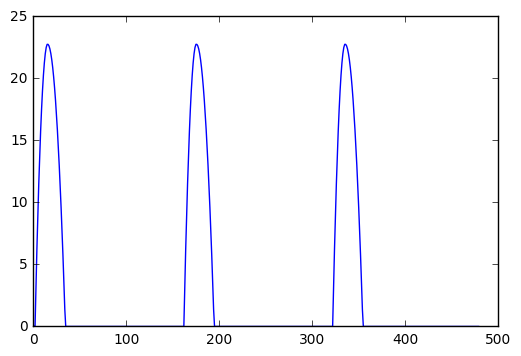

9
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [-0.25, 0.25, -2.59375], [0.0, 0.21875, -0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 1.0, 1.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 12.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


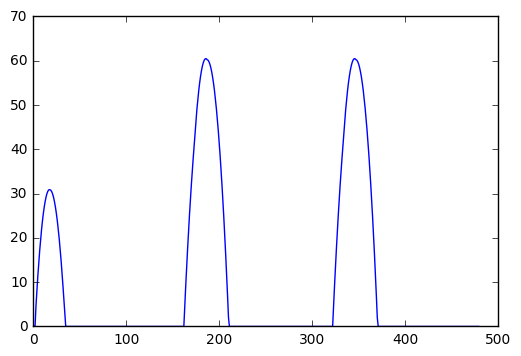

10
([[0.0, 0.0, 0.0], [0.0, 0.1875, -3.28125], [-0.25, 0.125, -2.59375], [0.0, 0.21875, -0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 1.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 24.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


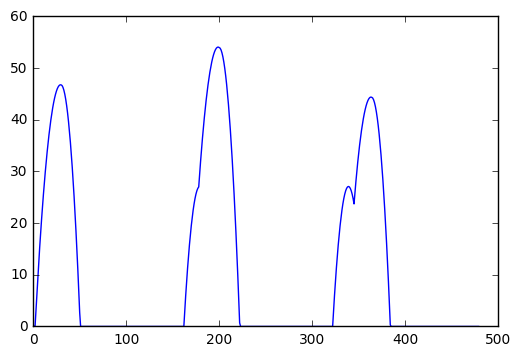

11
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.1875, -2.5625], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


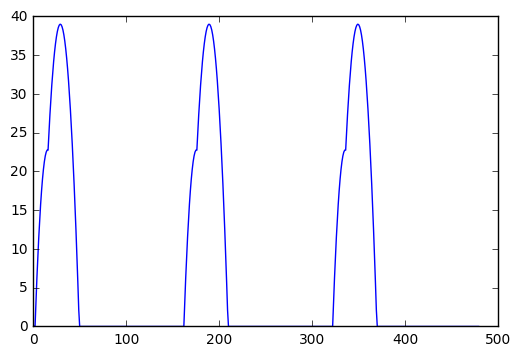

12
([[0.0, 0.0, 0.0], [0.0, 0.09375, -3.5], [0.0, 0.09375, -2.5625], [0.0, 0.09375, 0.0], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 2.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 4.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


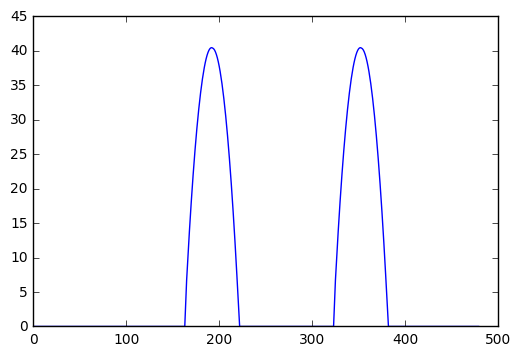

13
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [0.0, 0.1875, -0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


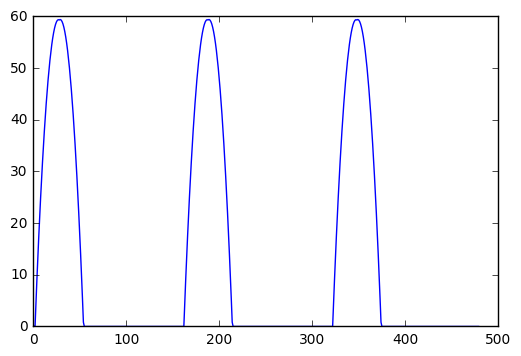

14
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [-0.25, 0.25, -2.59375], [0.0, 0.21875, -0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 1.0, 1.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 12.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


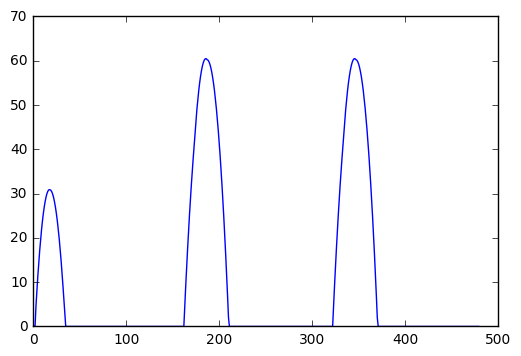

15
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.1875, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0, 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


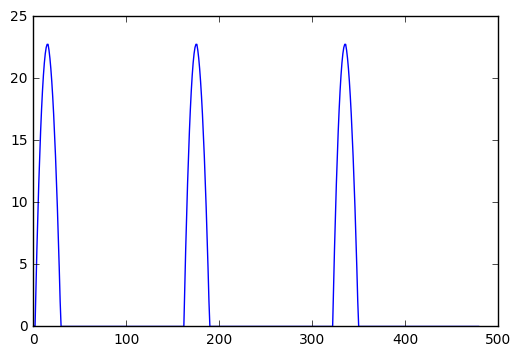

16
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.125, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


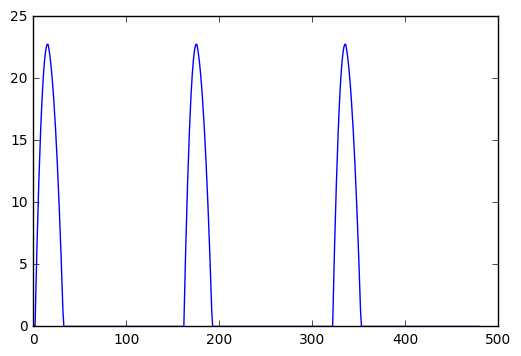

17
([[0.0, 0.0, 0.0], [0.0, 0.09375, -3.5], [0.0, 0.09375, -2.5625], [0.0, 0.09375, 0.0], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 2.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 4.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


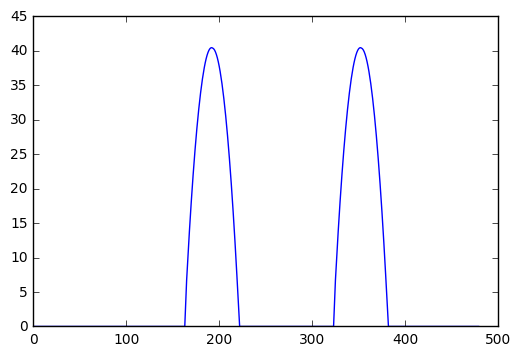

18
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [0.0, 0.09375, -2.5625], [0.0, 0.09375, 0.0], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 2.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 4.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


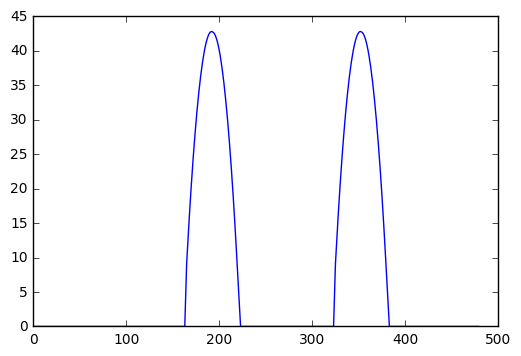

19
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.25], [0.0, 0.1875, -0.6875], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


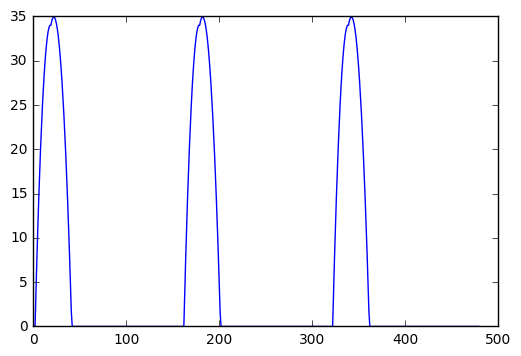

20
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [-0.25, 0.25, -2.59375], [0.0, 0.21875, -0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 1.0, 1.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 12.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


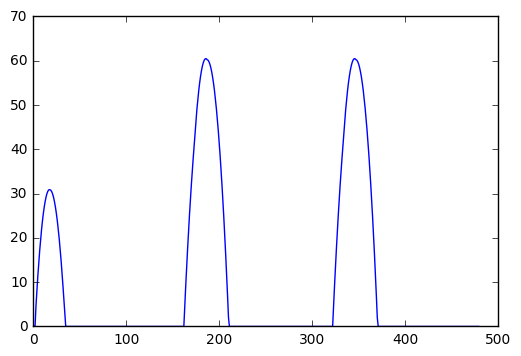

21
([[0.0, 0.0, 0.0], [0.0, 0.1875, -5.65625], [0.0, 0.28125, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


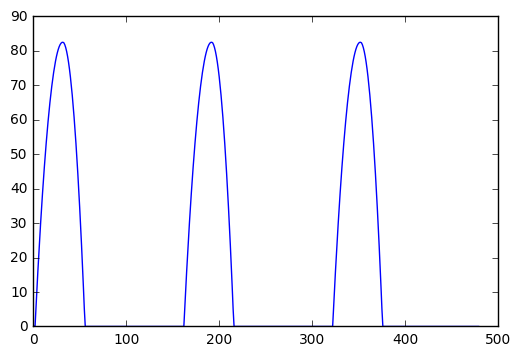

22
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.0, 0.25, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0, 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


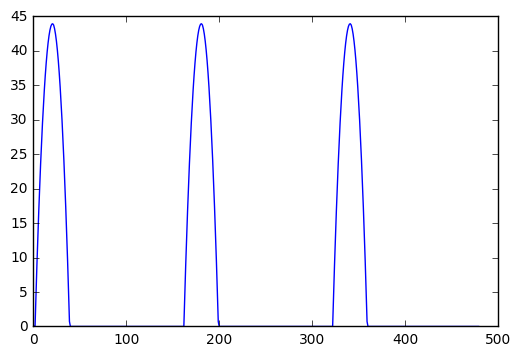

23
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [0.0, 0.25, -0.28125], [0.0, 0.21875, 'end'], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 1.0, 1.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 12.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])


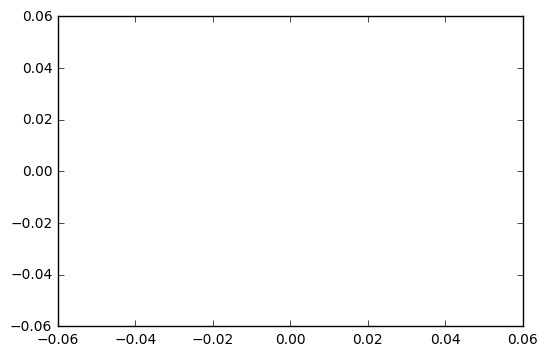

24
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.125, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


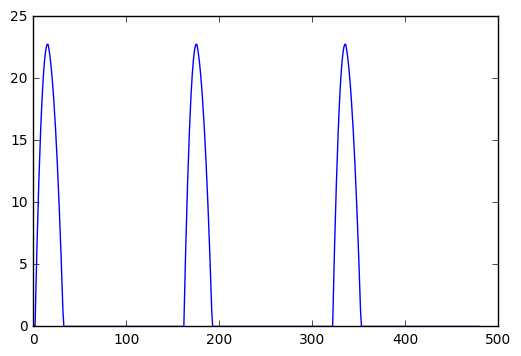

25
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.0, 0.1875, -0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 10.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


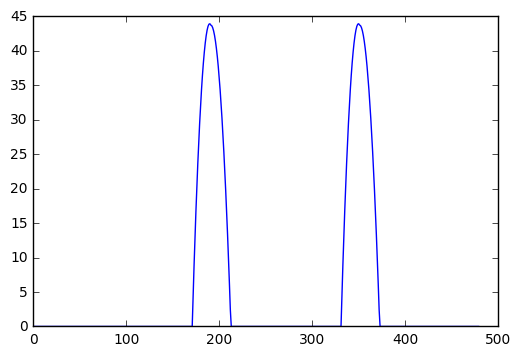

26
([[0.0, 0.0, 0.0], [0.0, 0.09375, -3.28125], [0.78125, 0.1875, -0.46875], [0.0, 0.09375, -0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 1.0, 1.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 24.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


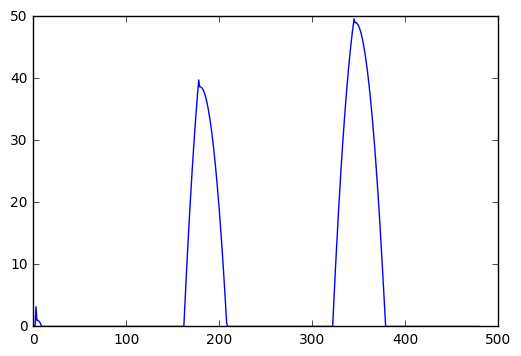

27
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [-0.25, 0.25, -2.59375], [0.0, 0.21875, -0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 1.0, 1.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 12.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


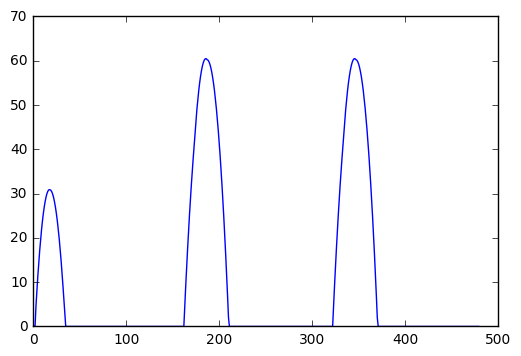

28
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.0, 0.25, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


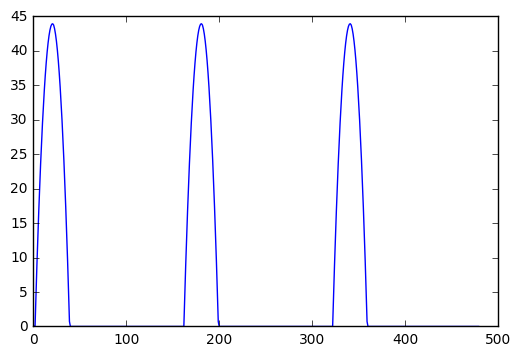

29
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.1875, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


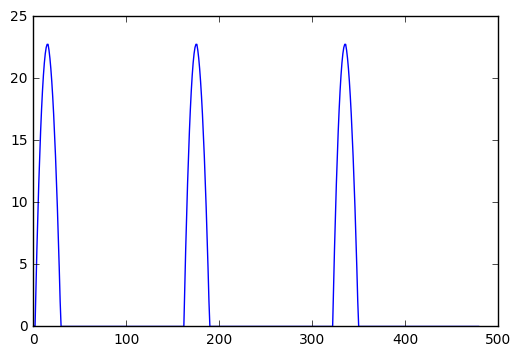

30
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [0.0, 0.09375, -0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


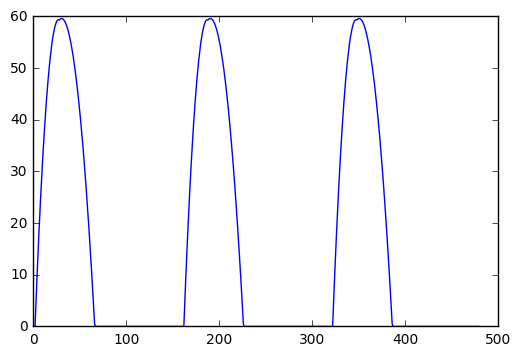

31
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.1875, 0.1875, -3.875], ['end', 0.25, 'end']], [(0, 1), (1, 2)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0]])


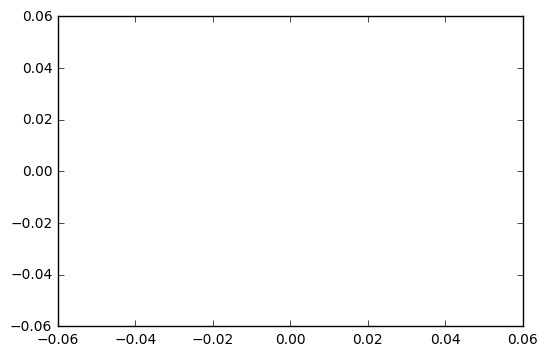

32
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.125, -2.5625], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


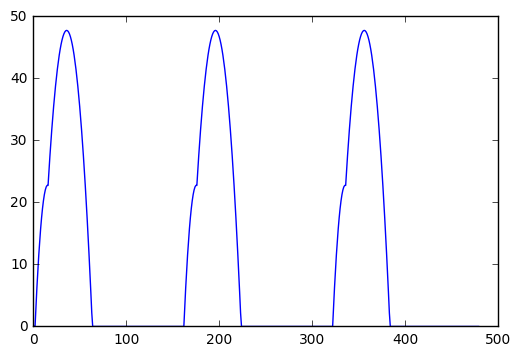

33
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.28125, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


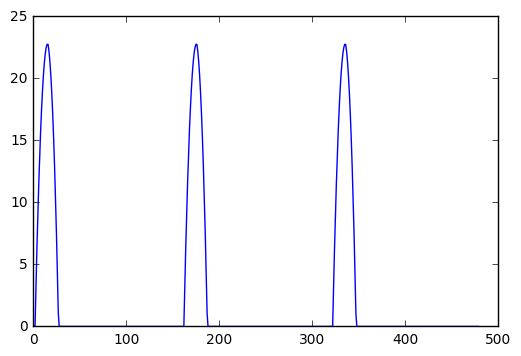

34
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.1875, 0.25, -3.875], [0.375, 0.375, 0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 4.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 8.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


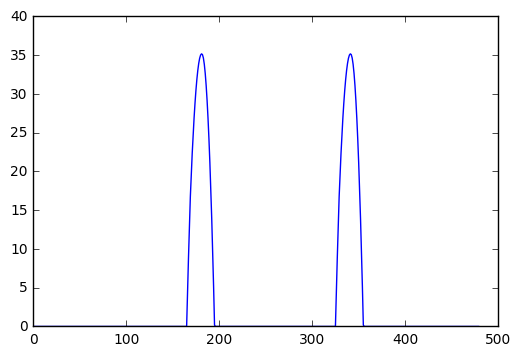

35
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.0, 0.1875, -3.875], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


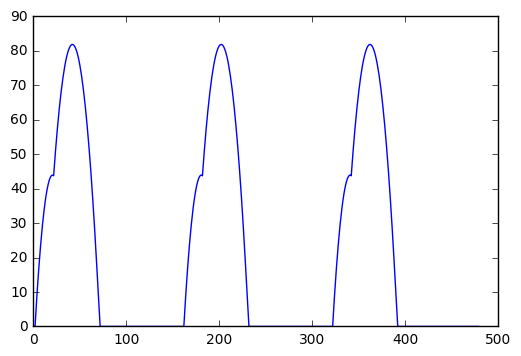

36
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.125, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


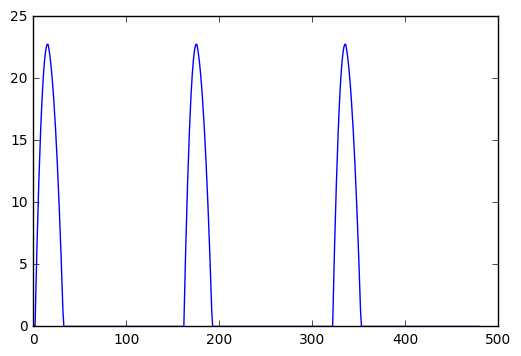

37
([[0.0, 0.0, 0.0], [0.0, 0.09375, -4.25], [0.0, 0.09375, -2.5625], [0.0, 0.09375, 0.0], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 2.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 4.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


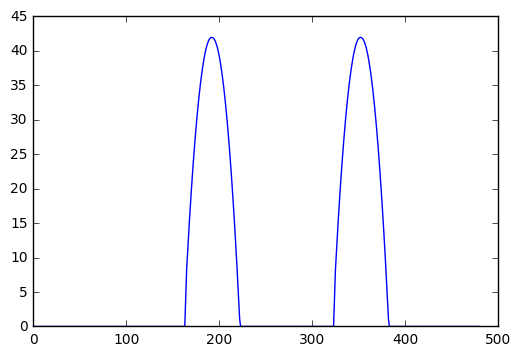

38
([[0.0, 0.0, 0.0], [0.0, 0.09375, -5.65625], [0.0, 0.125, -0.1875], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


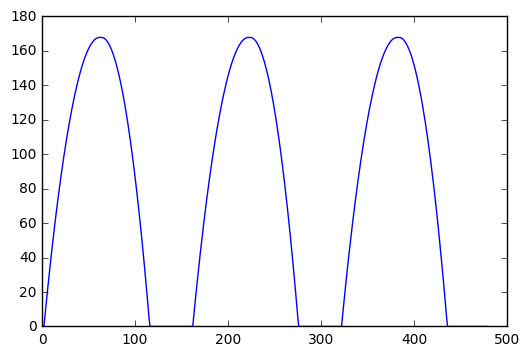

39
([[0.0, 0.0, 0.0], [0.0, 0.09375, -3.5], [0.0, 0.09375, -2.5625], [0.0, 0.09375, 0.0], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 2.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 4.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


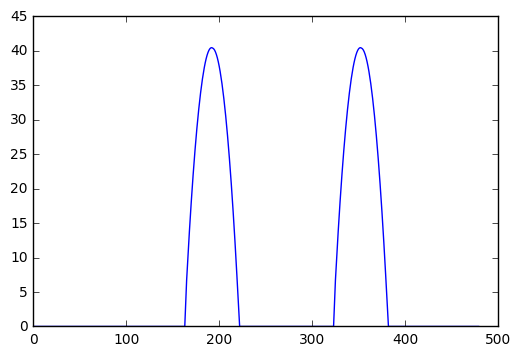

40
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [0.0, 0.25, -2.59375], [0.0, 0.21875, -0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 1.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 12.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


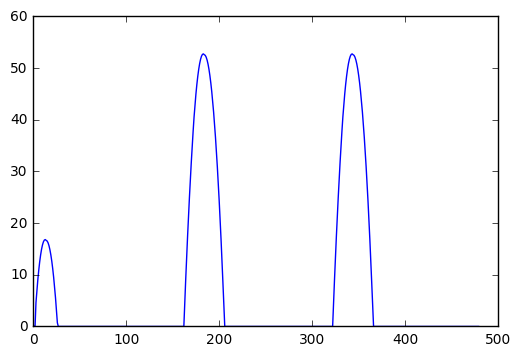

41
([[0.0, 0.0, 0.0], [0.0, 0.1875, -5.65625], [0.0, 0.21875, 0.09375], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


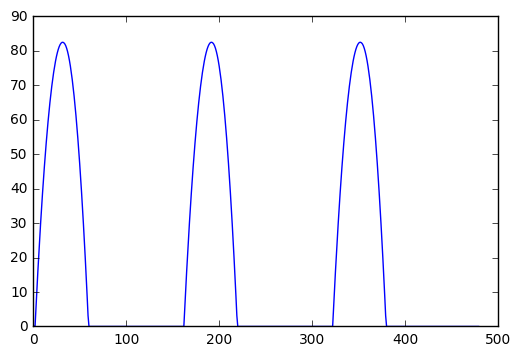

42
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [0.0, 0.125, -0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


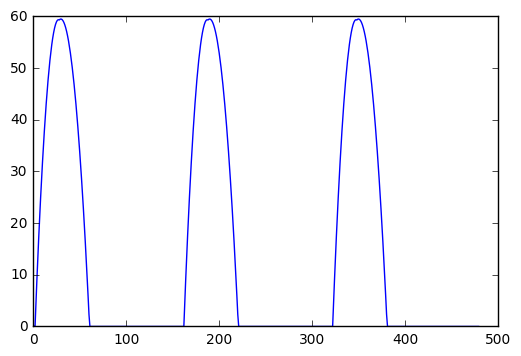

43
([[0.0, 0.0, 0.0], [0.0, 0.09375, -3.5], [0.0, 0.09375, -2.5625], [0.0, 0.09375, 0.0], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 3), (3, 0)], [['Button', 'Press', '>=', 2.0], ['Button', 'Release', ':', 'Button', 'Press', '>=', 4.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 3
transitioning  3 -> 0


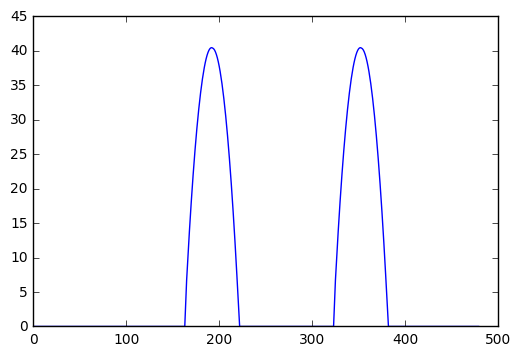

44
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.8125], [0.0, 0.25, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


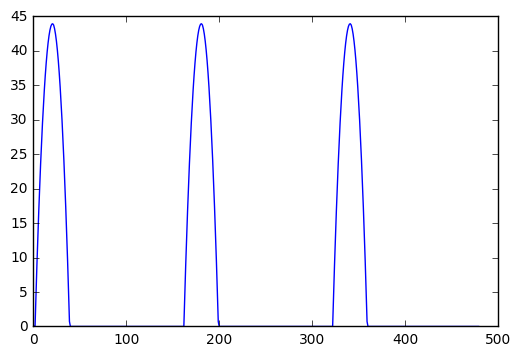

45
([[0.0, 0.0, 0.0], [0.0, 0.1875, -3.5], [0.0, 0.125, 0.0], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


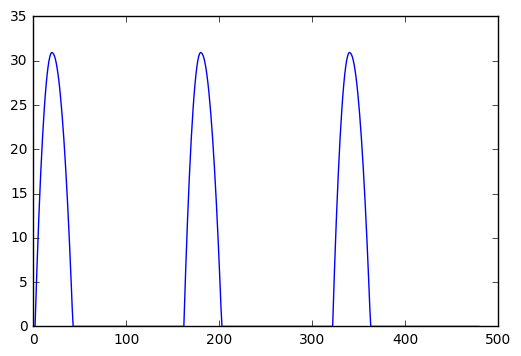

46
([[0.0, 0.0, 0.0], [0.0, 0.25, -4.25], [0.0, 0.1875, -0.6875], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


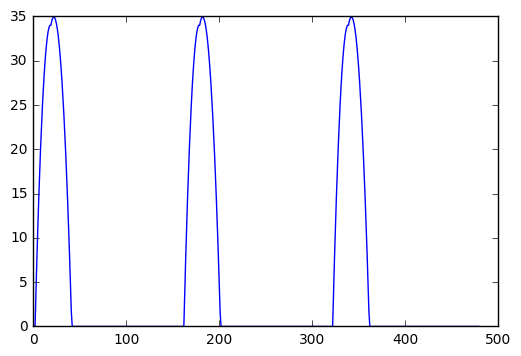

47
([[0.0, 0.0, 0.0], [0.0, 0.1875, -3.5], [0.0, 0.125, 0.0], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


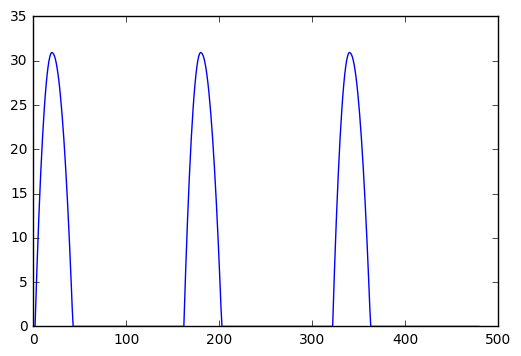

48
([[0.0, 0.0, 0.0], [0.0, 0.25, -3.5], [0.0, 0.28125, 0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


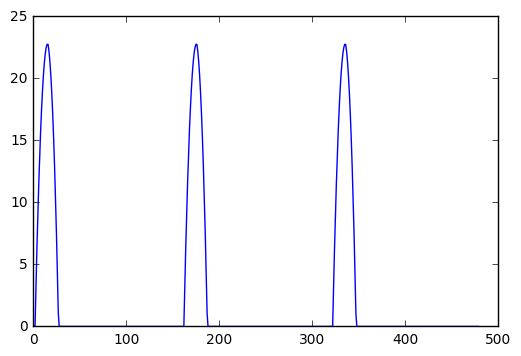

49
([[0.0, 0.0, 0.0], [0.0, 0.1875, -4.8125], [0.0, 0.21875, -0.28125], ['end', 'end', 'end']], [(0, 1), (1, 2), (2, 0)], [['Button', 'Press', '>=', 1.0], ['dy', '<=', 0.0], ['Collision', 'Bottom']])
1
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
16
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0
31
transitioning  0 -> 1
transitioning  1 -> 2
transitioning  2 -> 0


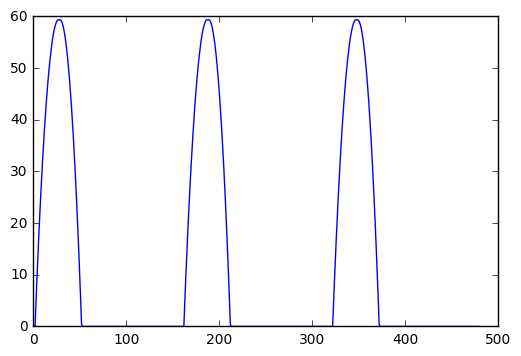

In [78]:
def make_transition_function(func):
    transitions = []
    current_transition = None
    is_button = False
    is_press = False
    is_collision = False
    collision_dir = ''
    function = ''
    var = ''
    for f in func:
        #print 'parsing', f
        if f == 'Button':
            is_button = True
            #print 'is_button = True'
        elif is_button and f == 'Release':
            is_button = False
            is_press = False
            function = ''
            var = ''
            is_collision = False
            #print 'Released = True'
            collision_dir = ''
            current_transition = lambda y,dy,t,pressed: t > pressed
        elif is_button and f == 'Press':
            is_press = True
            #print 'Press = True'
        elif f == '>=' or  f == '<=':
            function = f
            #print 'function = ',f
        elif is_press and function != '':
            if  function == '>=':
                #print 'making pressed >=',f
                current_transition = lambda y,dy,t,pressed: t >= f and pressed >= f
            if  function == '<=':
                #print 'making pressed <=',f
                current_transition = lambda y,dy,t,pressed: t <= f and pressed >= f
            #print 'HERE',current_transition
                
            is_button = False
            is_press = False
            function = ''
            var = ''
            is_collision = False
            collision_dir = ''
            var = ''
        elif f in ['dy','y']:
            var = f
        elif var != '':
            if var == 'dy':
                if  function == '>=':
                    current_transition = lambda y,dy,t,pressed: dy >= f
                if  function == '<=':
                    current_transition = lambda y,dy,t,pressed: dy <= f
            if var == 'y':
                if  function == '>=':
                    current_transition = lambda y,dy,t,pressed: y >= f
                if  function == '<=':
                    current_transition = lambda y,dy,t,pressed: y <= f
            
            is_button = False
            is_press = False
            function = ''
            var = ''
            is_collision = False
            collision_dir = ''
        elif f == 'Collision':
            is_collision = True
        elif is_collision and f in ['Bottom']:
            current_transition = lambda y,dy,t,pressed: y <= 0            
            is_button = False
            is_press = False
            function = ''
            var = ''
            is_collision = False
            collision_dir = ''       
            
        if f == ':':
            #print 'HERE?',current_transition
            transitions.append(current_transition)
            is_button = False
            is_press = False
            function = ''
            var = ''
            is_collision = False
            collision_dir = ''
        
    transitions.append(current_transition)
    
    def transition(y,dy,t,pressed):
        for trans in transitions:
            if trans(y,dy,t,pressed):
                return True
        return False
    return transition


def test_ha(ha,min_press=1,max_press=32,press_interval=15):
    print ha
    modes = ha[0]
    transitions = {}
    for mode in modes[:-1]:
        if 'end' in mode:
            return []
    for transition,transition_function in zip(ha[1],ha[2]):
        from_mode = transition[0]
        to_mode = transition[1]
        if from_mode not in transitions:
            transitions[from_mode] = []
        transitions[from_mode].append((make_transition_function(transition_function),to_mode))
    #print len(transitions),len(modes)
    if len(transitions) != len(modes)-1:
        return []
    saved_positions = []
    for press in range(min_press,max_press,press_interval):
        current_mode = 0
        pos = 0
        vel = 0
        print press
        for t in range(max_press*5):
            saved_positions.append(pos)
            vel -= modes[current_mode][1]
            pos += vel
            if pos <= 0:
                pos = 0
            for transition in transitions[current_mode]:
                #print pos,vel,t,press
                if transition[0](pos,vel,t,press):
                    print 'transitioning ', current_mode,'->',transition[1]
                    current_mode = transition[1]
                    if current_mode == 0:
                        press = 0
                    vel = -(modes[current_mode][0]*vel+modes[current_mode][2])
    return saved_positions
   
    
for ha_id in range(0,50):
    print ha_id
    positions = np.array(test_ha(has[ha_id]))
    import matplotlib.pyplot as plt

    plt.plot(positions)
    plt.show()